# 9.8 Self study

The following parts are not covered during the taught session and are for self-study.

##  Optimising with NumPy 

*Relevant notebook: 9.2 Optimising with NumPy*

Note that we might worry that we carry on calculating the mandelbrot values for points that have already diverged.

### Attempt 3: Reduce number of operations

In [1]:
def mandel_reduce_operations(constants, max_iterations=50):
    
    # todo add comments here
    value = np.zeros(constants.shape) + constants
    calculating = np.ones(constants.shape, dtype="bool") 
    diverged_at_count = np.ones(constants.shape)*max_iterations
    
    counter = 0
    while counter < max_iterations:
        value[calculating] = value[calculating] ** 2 + constants[calculating]
        diverging_now = np.zeros(constants.shape, dtype="bool")
        
        # undo this bit, put it back to *
        diverging_now[calculating] = (
            value[calculating] * np.conj(value[calculating]) > 4
        )
        
        calculating = np.logical_and(calculating, np.logical_not(diverging_now))
        diverged_at_count[diverging_now] = counter
        counter = counter + 1

    return diverged_at_count

In [2]:
import numpy as np
import matplotlib.pyplot as plt

xmin = -1.5
ymin = -1.0
xmax = 0.5
ymax = 1.0
resolution = 300
xstep = (xmax - xmin) / resolution
ystep = (ymax - ymin) / resolution
xs = [(xmin + xstep * i) for i in range(resolution)]
ys = [(ymin + ystep * i) for i in range(resolution)]
# list with complex values
cs_listcomp = [[(x + y*1j) for x in xs] for y in ys]
cs = np.asarray(cs_listcomp)

In [3]:
result_reduce_operations = mandel_reduce_operations(cs)

In [4]:
%%timeit

mandel_reduce_operations(cs)

47.2 ms ± 1.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


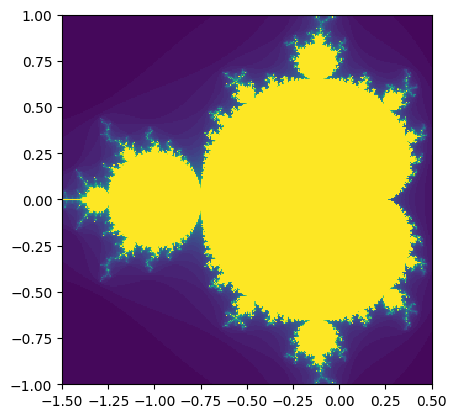

In [5]:
plt.imshow(result_reduce_operations, interpolation="none", extent=[xmin, xmax, ymin, ymax])

This was **not faster** even though it was **doing less work**. This often happens: on modern computers, **branches** (if statements, function calls) and **memory access** is usually the rate-determining step, not maths. Complicating your logic to avoid calculations sometimes therefore slows you down. The only way to know is to **measure**.You need to *experiment* to see which optimisations will work. Performance programming needs to be empirical.

## Optimising with Cython 

*Relevant notebook: 9.3 Optimising with Cython*

### Calling C functions from Cython

**Example: compare `sin()` from Python and C library**

In [6]:
%load_ext Cython

In [7]:
%%cython
import math
cpdef py_sin():
    cdef int x
    cdef double y
    for x in range(1e7):
        y = math.sin(x)

In [8]:
%%cython
from libc.math cimport sin as csin # import from C library
cpdef c_sin():
    cdef int x
    cdef double y
    for x in range(1e7):
        y = csin(x)

In [9]:
%%timeit 
[math.sin(i) for i in range(int(1e7))] # python

1.66 s ± 30.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%%timeit 
py_sin()   

873 ms ± 34.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%%timeit 
c_sin()  

5.03 ms ± 57.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Optimising with Numba

*Relevant notebook: 9.4 Optimising with Numba*

### Parallelising Mandelbrot

In [12]:
cs = [[(x + y*1j) for x in xs] for y in ys]
print(len(cs))
print(type(cs[0]))

300
<class 'list'>


In [13]:
map(len, cs[0:10])

In [14]:
list(map(len, cs[0:10]))

[300, 300, 300, 300, 300, 300, 300, 300, 300, 300]

In [15]:
%%writefile mandelrow.py
def mandel(position, limit=50):
    value = position
    while abs(value) < 2:
        limit -= 1
        value = value**2 + position
        if limit < 0:
            return 0
    return limit

def mandel_row(row):
    """Apply mandel to a row."""
    return [mandel(cell) for cell in row]

assert mandel_row([1, 2, 3]) == [49, 50, 50]

Overwriting mandelrow.py


In [16]:
from mandelrow import mandel_row

In [17]:
%%timeit
list(map(mandel_row, cs))

432 ms ± 11.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
zs = list(map(mandel_row, cs))

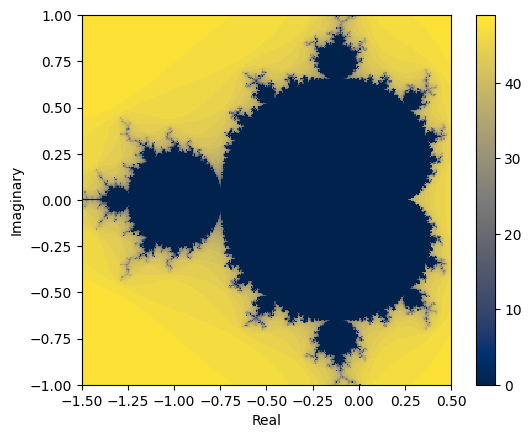

In [19]:
plt.set_cmap("cividis")  # use a color vision deficiency-friendly palette
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.imshow(
    zs,
    interpolation="none",
    extent=[xmin, xmax, ymin, ymax],
    origin="lower"
)
plt.colorbar()

In [20]:
from multiprocessing import Pool
from os import cpu_count

with Pool(cpu_count()) as pool:
    p_zs = pool.map(mandel_row, cs)

In [21]:
%%timeit pool = Pool(cpu_count())

pool.map(mandel_row, cs)

100 ms ± 5.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
pool.close()

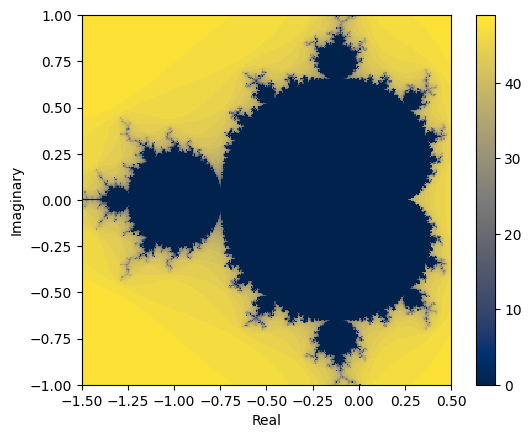

In [23]:
plt.set_cmap("cividis")  # use a color vision deficiency-friendly palette
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.imshow(
    p_zs,
    interpolation="none",
    extent=[xmin, xmax, ymin, ymax],
    origin="lower"
)
plt.colorbar()

## Performance Scaling

*Relevant notebook: 9.5 Performance scaling for containers and algorithms*

We will continue our performance comparison of lists and arrays by looking at accessing elements in the middle.

In [24]:
counts = np.arange(1, 100000, 10000)

In [25]:
def time_lookup_middle_element_in_list(count):
    test_list = [0] * count
    middle_position = count // 2

    def totime():
        return test_list[middle_position]

    return repeat(totime, number=10000)

In [26]:
def time_lookup_middle_element_in_ndarray(count):
    test_array = np.ndarray(count)
    middle_position = count // 2

    def totime():
        return test_array[middle_position]

    return repeat(totime, number=10000)

In [27]:
def plot_time(function, counts, title=None, top=None):
    plt.plot(counts, list(map(function, counts)))
    plt.ylim(bottom=0, top=top)
    plt.ylabel("seconds")
    plt.xlabel("array size")
    plt.title(title or function.__name__)

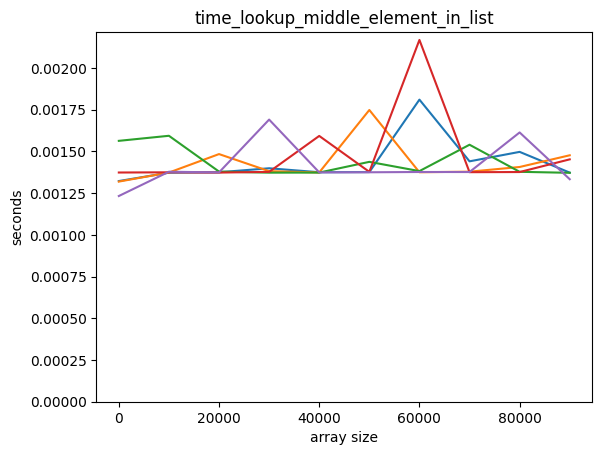

In [28]:
from timeit import repeat

plot_time(time_lookup_middle_element_in_list, counts)

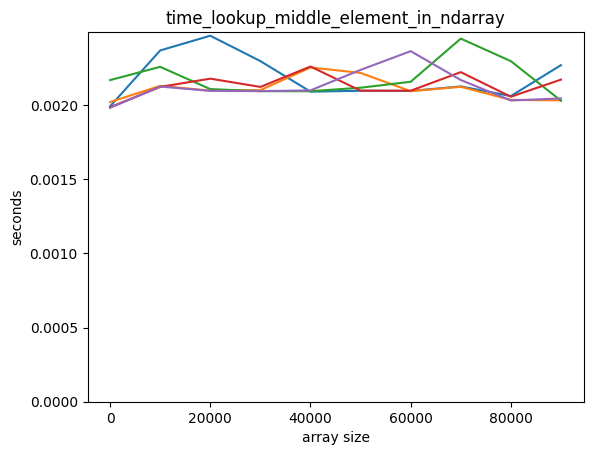

In [29]:
plot_time(time_lookup_middle_element_in_ndarray, counts)

Both scale well for accessing the middle element.

What about inserting at the beginning?

If we want to insert an element at the beginning of a Python list we can do:

In [30]:
x = list(range(5))
x

[0, 1, 2, 3, 4]

In [31]:
x[0:0] = [-1]
x

[-1, 0, 1, 2, 3, 4]

In [32]:
def time_insert_to_list(count):
    return repeat("before[0:0] = [0]", f"before = [0] * {count}", number=10000)

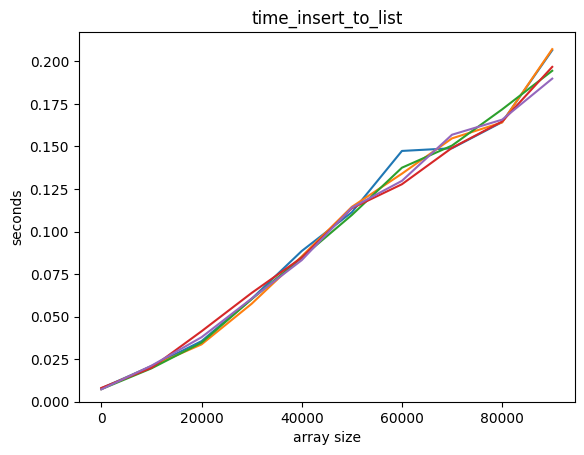

In [33]:
plot_time(time_insert_to_list, counts)

`list` performs **badly** for insertions at the beginning!

There are containers in Python that work well for insertion at the start:

In [34]:
from collections import deque

In [35]:
def time_insert_to_deque(count):
    return repeat(
        "before.appendleft(0)",
        f"from collections import deque; before = deque([0] * {count})",
        number=10000,
    )

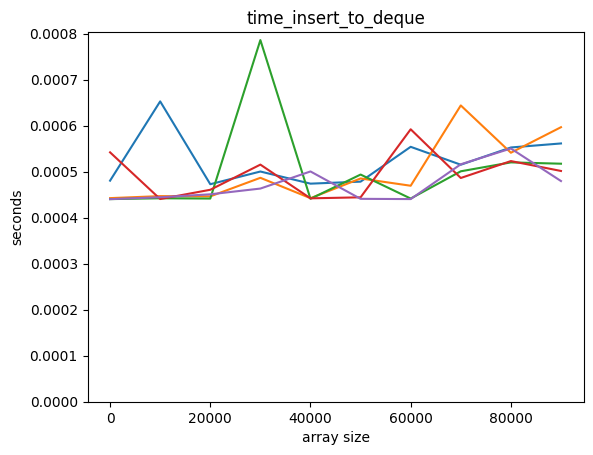

In [36]:
plot_time(time_insert_to_deque, counts)

But looking up in the middle scales badly:

In [37]:
def time_lookup_middle_element_in_deque(count):
    test_deque = deque([0] * count)
    middle_position = count // 2

    def totime():
        return test_deque[middle_position]

    return repeat(totime, number=10000)

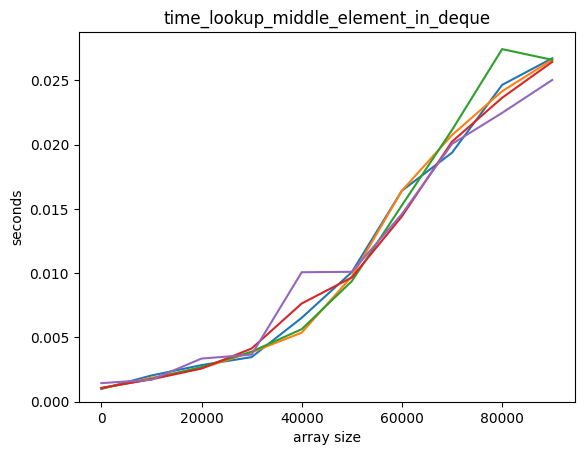

In [38]:
plot_time(time_lookup_middle_element_in_deque, counts)

What is going on here?

Arrays are stored as contiguous memory. Anything which changes the length of the array requires the whole array to be copied elsewhere in memory.

This copy takes time proportional to the array size.

![Adding an element to an array - memory representation](./array_memory.svg)

The Python `list` type is **also** an array, but it is allocated with **extra memory**. Only when that memory is exhausted is a copy needed.

![Adding an element to a list - memory representation](list_memory.svg)

If the extra memory is typically the size of the current array, a copy is needed every 1/N appends, and costs N to make, so **on average** copies are cheap. We call this **amortized constant time**. 

This makes it fast to look up values in the middle. However, it may also use more space than is needed.

The deque type works differently: each element contains a pointer to the next. Inserting elements is therefore very cheap, but looking up the Nth element requires traversing N such pointers.

![Adding an element to a deque - memory representation](deque_memory.svg)

## Dictionary performance

For another example, let's consider the performance of a dictionary versus a couple of other ways in which we could implement an associative array.

In [39]:
class evildict:
    def __init__(self, data):
        self.data = data

    def __getitem__(self, akey):
        for key, value in self.data:
            if key == akey:
                return value
        raise KeyError()

If we have an evil dictionary of N elements, how long would it take - on average - to find an element?

In [40]:
eric = [["Name", "Eric Idle"], ["Job", "Comedian"], ["Home", "London"]]

In [41]:
eric_evil = evildict(eric)

In [42]:
eric_evil["Job"]

'Comedian'

In [43]:
eric_dict = dict(eric)

In [44]:
eric_evil["Job"]

'Comedian'

In [45]:
x = ["Hello", "License", "Fish", "Eric", "Pet", "Halibut"]

In [46]:
sorted(x, key=lambda el: el.lower())

['Eric', 'Fish', 'Halibut', 'Hello', 'License', 'Pet']

What if we created a dictionary where we bisect the search?

In [47]:
from bisect import bisect_left


class sorteddict:
    def __init__(self, data):
        self.data = sorted(data, key=lambda x: x[0])
        self.keys = list(map(lambda x: x[0], self.data))

    def __getitem__(self, akey):
        loc = bisect_left(self.keys, akey)

        if loc != len(self.data):
            return self.data[loc][1]

        raise KeyError()

In [48]:
eric_sorted = sorteddict(eric)

In [49]:
eric_sorted["Job"]

'Comedian'

In [50]:
def time_dict_generic(ttype, count):
    keys = list(range(count))
    values = [0] * count
    data = ttype(list(zip(keys, values)))

    def totime():
        return data[keys[count // 2]]

    return repeat(totime, number=10000)

In [51]:
def time_dict(count):
    return time_dict_generic(dict, count)


def time_sorted(count):
    return time_dict_generic(sorteddict, count)


def time_evil(count):
    return time_dict_generic(evildict, count)

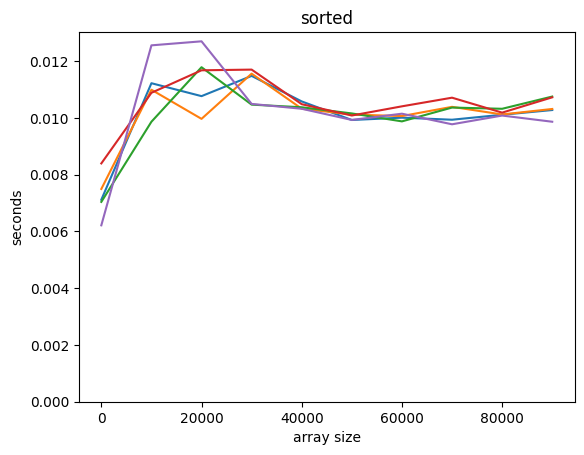

In [52]:
plot_time(time_sorted, counts, title="sorted")

We can't really see what's going on here for the sorted example as there's too much noise, but theoretically we should get **logarithmic** asymptotic performance. We write this down as $O(\ln N)$. This doesn't mean there isn't also a constant term, or a term proportional to something that grows slower (such as $\ln(\ln N)$): we always write down just the term that is dominant for large $N$. We saw before that `list` is $O(1)$ for appends, $O(N)$ for inserts. Numpy's `array` is $O(N)$ for appends.

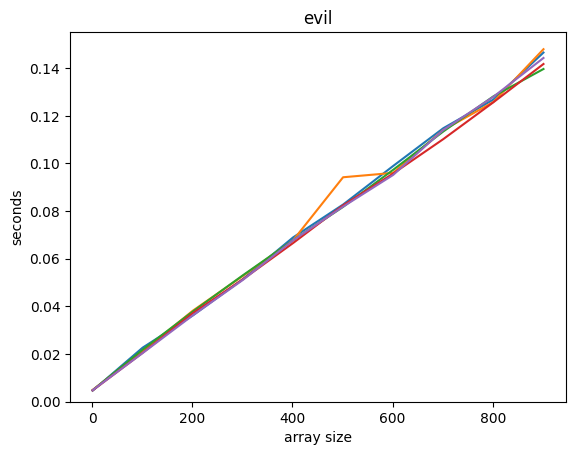

In [53]:
counts = np.arange(1, 1000, 100)
plot_time(time_evil, counts, title="evil")

The simple check-each-in-turn solution is $O(N)$ - linear time.

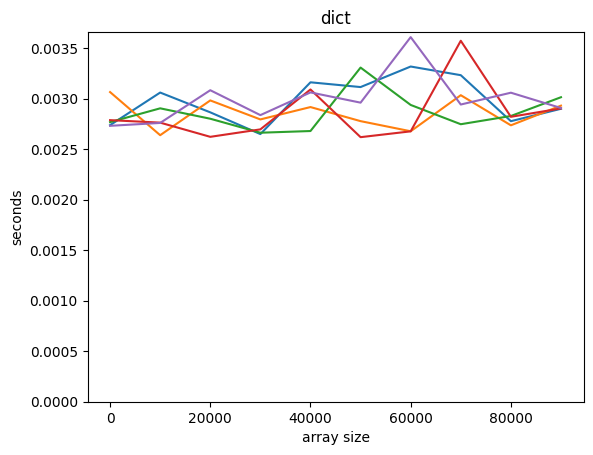

In [54]:
counts = np.arange(1, 100000, 10000)
plot_time(time_dict, counts, title="dict")

Python's built-in dictionary is, amazingly, O(1): the time is **independent** of the size of the dictionary.

This uses a miracle of programming called the _Hash Table_:
you can learn more about [these issues at this video from Harvard University](https://www.youtube.com/watch?v=h2d9b_nEzoA). This material is pretty advanced, but, I think, really interesting!